## Inizialization and loading data

In [112]:
# necessary import
import pandas as pd
import numpy as np
import os, cv2, random, pickle
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader
from scipy.stats import ks_2samp
from scipy import stats
size = 224

In [27]:
# utility function
def image_import (img_path, class_type, appended_list):
    for i in os.listdir(img_path):
        read_path = os.path.join(img_path, i)
       # print(i)
        try:
            img = cv2.imread(read_path)
            img = cv2.resize(img, (size, size))
            appended_list.append([img, class_type])
        except Exception as e:
            print(f'Image error: {i}')
            pass
# utility function
def image_preprocess (img_path, appended_list):
    for i in os.listdir(img_path):
        read_path = os.path.join(img_path, i)
        print(i)
        try:
            img = cv2.imread(read_path)
            img = cv2.resize(img, (size, size))
            appended_list.append(img)
        except Exception as e:
            print(f'Image error: {i}')
            pass

In [3]:
# run params
section = 'vae'
data_name = 'x-ray_old'
run_id = '0004'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])
#BATCH_SIZE = 2000
INPUT_DIM = (224,224,3)
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [4]:
# load data
#import pneumonia testng data
#train_dir = "data/X-ray_dataset_old/chest_xray/train"
#train = data_gen.flow_from_directory(train_dir, 
 #                                           batch_size=BATCH_SIZE, 
  #                                          shuffle=True,
  #                                          class_mode='input',
  #                                          target_size=INPUT_DIM[:2])
#print(train)
#img_path = 'data/X-ray_dataset_old/chest_xray/train/PNEUMONIA'
#training_data_old=[]
#image_import(img_path, 1, training_data_old)

#import normal lung testing data
#img_path = 'data/X-ray_dataset_old/chest_xray/train/NORMAL'
#image_import(img_path,0, training_data_old)

#shuffle training_data
#random.shuffle(training_data_old)


img_path = 'data/X-ray_dataset_old/chest_xray/test/PNEUMONIA'
testing_data_old=[]
image_import(img_path, 1, testing_data_old)

#import normal lung testing data
img_path = 'data/X-ray_dataset_old/chest_xray/test/NORMAL'
image_import(img_path,0, testing_data_old)

#shuffle training_data
random.shuffle(testing_data_old)
#seperate testing to XY
test_features_old = []
test_targets_old = []

for f, t in testing_data_old:
    test_features_old.append(f)
    test_targets_old.append(t)

test_features_old = np.array(test_features_old).reshape(-1, size, size, 3)
test_targets_old = np.array(test_targets_old)   
test_features_old = test_features_old/255

## Train Data

### Average image training data 

In [5]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)
train_latent_space="data/X-ray_dataset_old/chest_xray/train/latent_space_train.csv"
#z_points_old = vae.encoder.predict(train_features_old[5000:5001,:,:,:])
#df=pd.DataFrame(z_points_old)
#df.to_csv('z_points.csv')
z_points_old_df=pd.read_csv(train_latent_space)
z_points_old=z_points_old_df.to_numpy()
z_points_old.shape

(5214, 100)

(1, 100)
Populating the interactive namespace from numpy and matplotlib


/home/chiara/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'random', 'size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


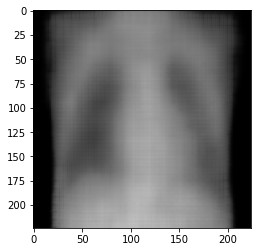

In [6]:
avg_img=np.mean(z_points_old,axis=0)
avg_img=avg_img.reshape(1,100)
print(avg_img.shape)
reconst_avg_img = vae.decoder.predict(avg_img)
%pylab inline
imgplot = plt.imshow(reconst_avg_img.squeeze(),cmap='gray_r')
plt.show()

### Dimensions distribution

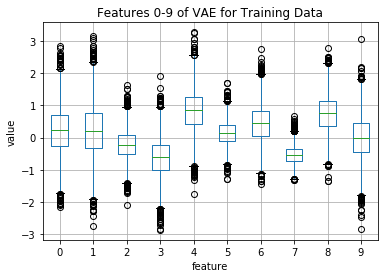

In [8]:
#dim_x=np.shape(z_points_old)[0]
#x=np.linspace(0,100,dim_x)
#for col in range(np.shape(z_points_old)[1]):
#    plt.figure()
#    plt.plot(x,z_points_old[:,col])
#    direct='figures/0004/distribution_train/scatter/dim{}.png'.format(col)
#    plt.savefig(direct)
fig_name="figures/0004/distribution_train/boxplot/features0-9.png"

lSpaceDF = pd.read_csv(train_latent_space)

#print(lSpaceDF.head())

first10 = lSpaceDF.iloc[:,0:10]

first10.boxplot()
plt.xlabel('feature')
plt.ylabel('value')
plt.title('Features 0-9 of VAE for Training Data')
plt.savefig(fig_name)
plt.show()

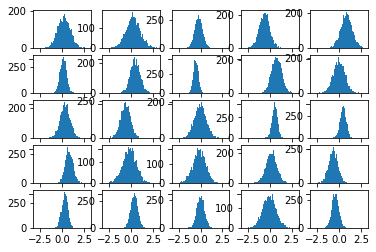

In [9]:
fig, ax = plt.subplots(5,5)

for i in range(5):
    for j in range(5):
        idx = (i*5)+j
        feature = lSpaceDF.iloc[:,idx]

        ax[i,j].hist(feature.values,bins=100,range=[-3,3])

plt.show()
plt.close()


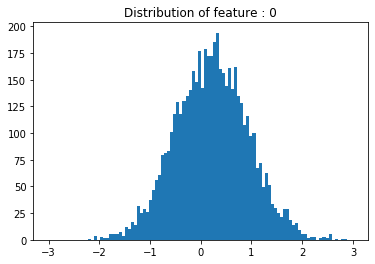

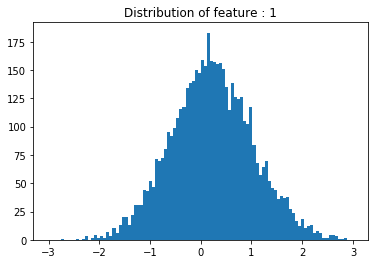

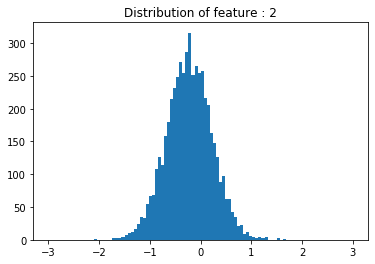

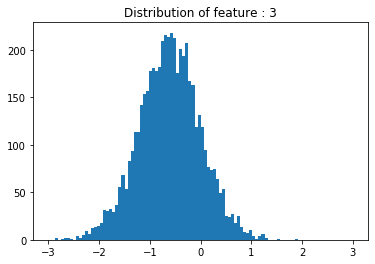

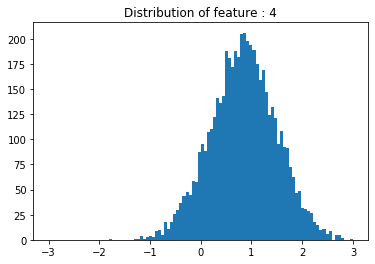

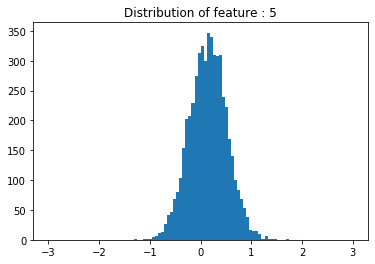

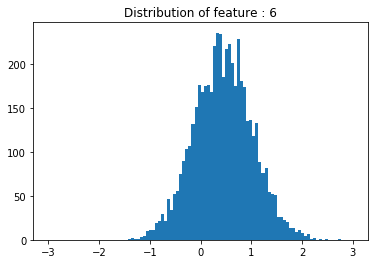

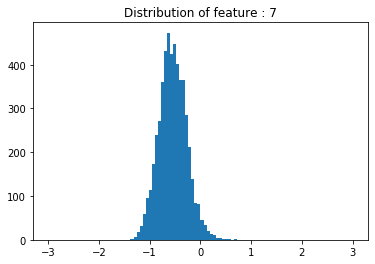

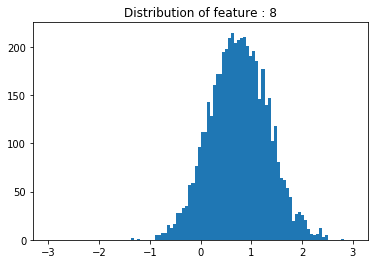

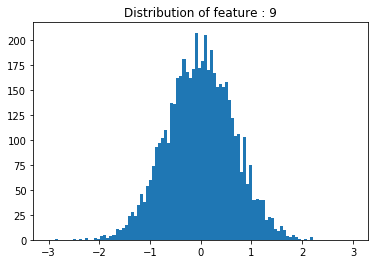

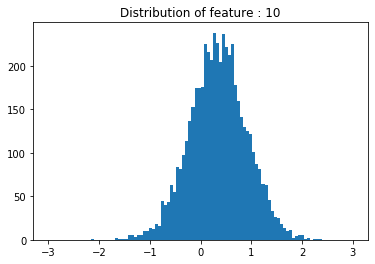

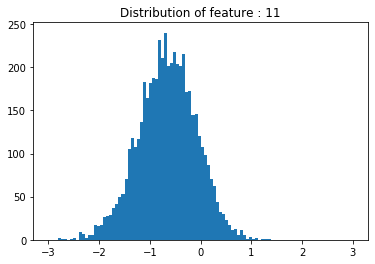

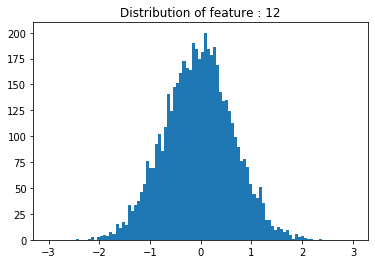

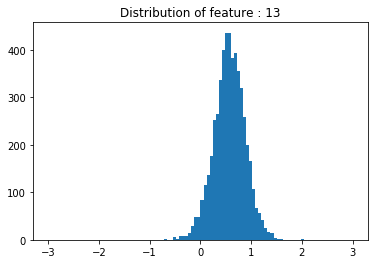

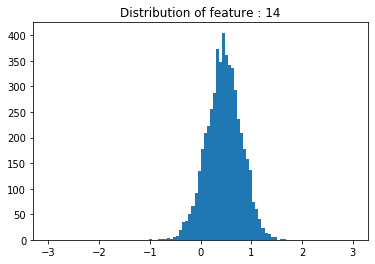

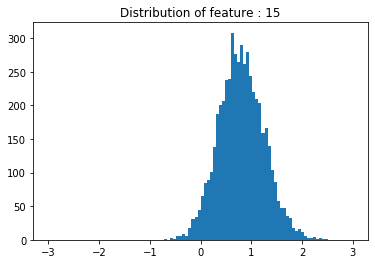

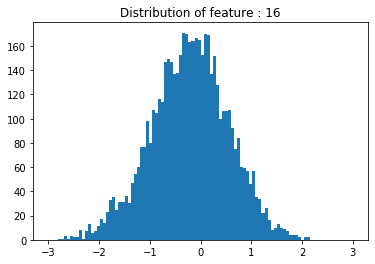

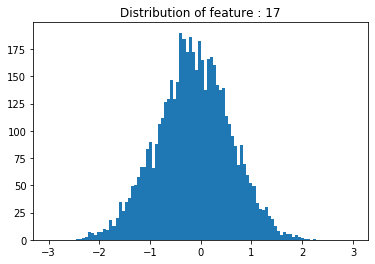

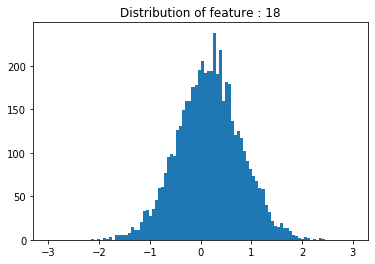

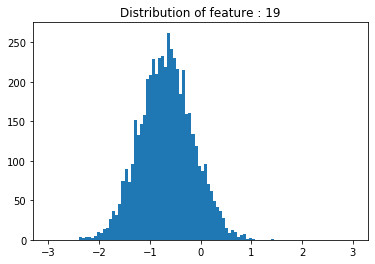

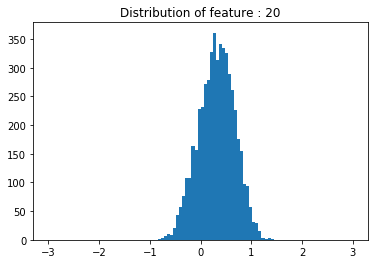

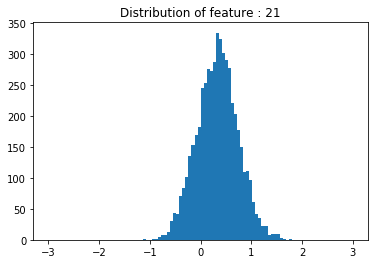

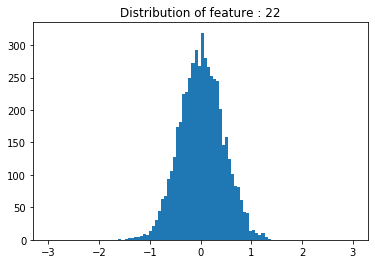

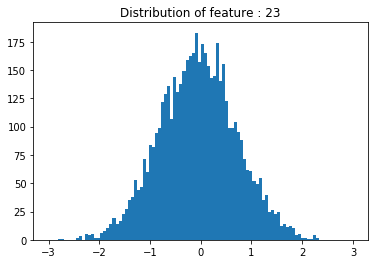

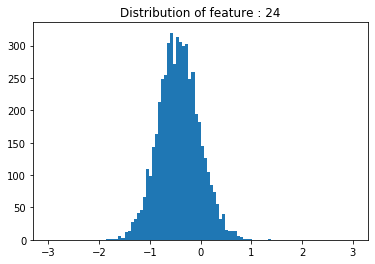

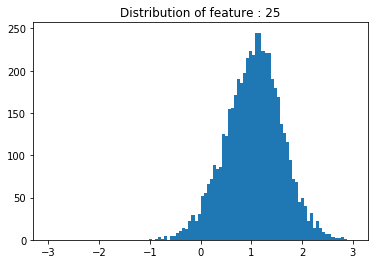

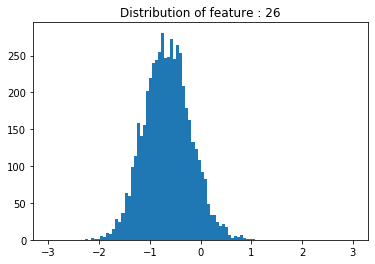

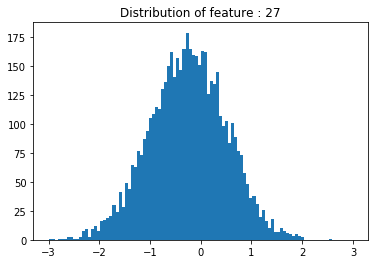

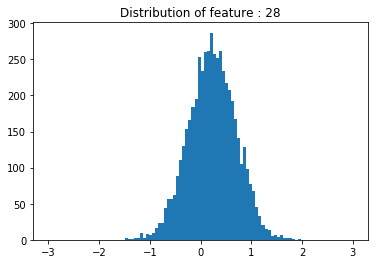

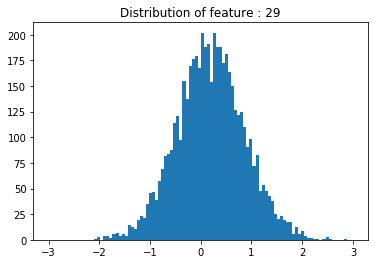

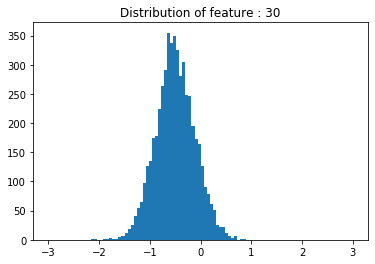

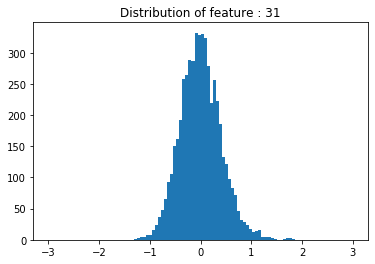

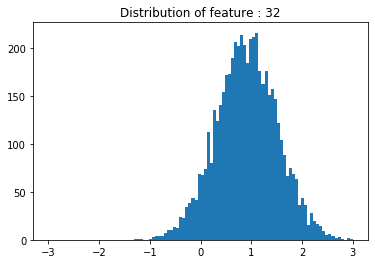

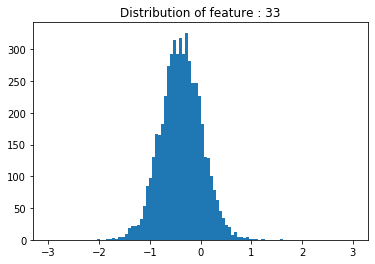

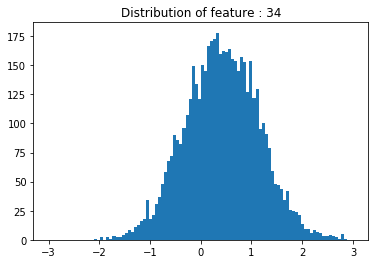

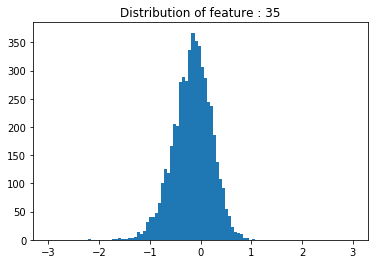

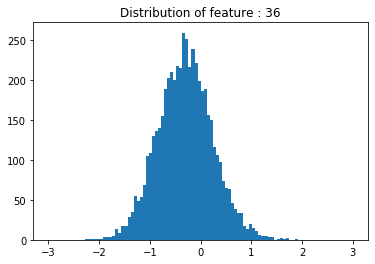

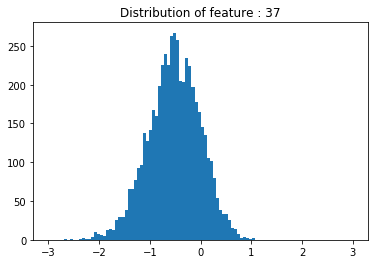

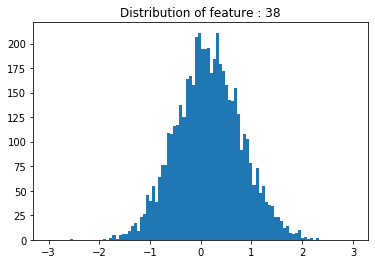

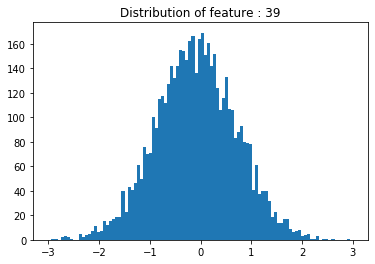

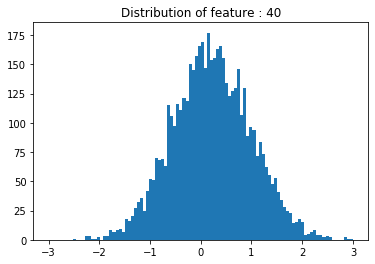

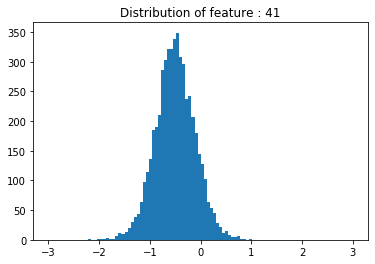

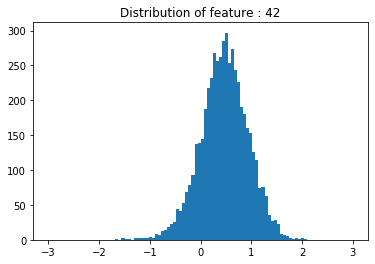

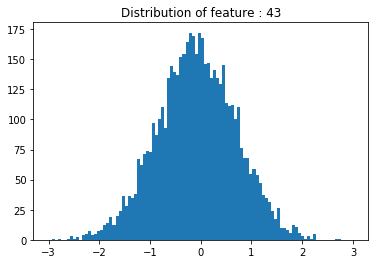

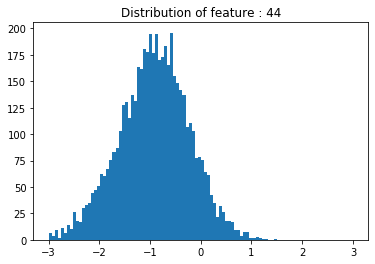

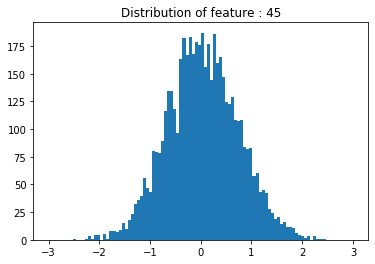

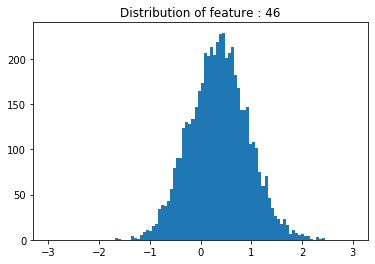

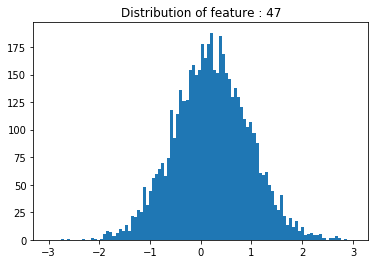

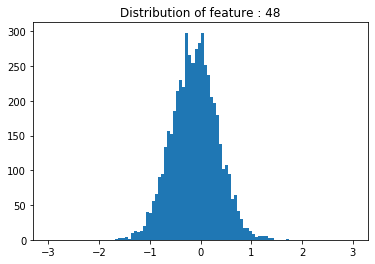

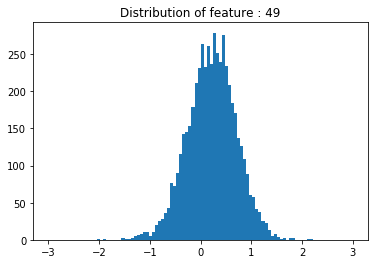

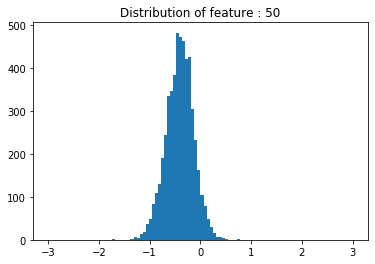

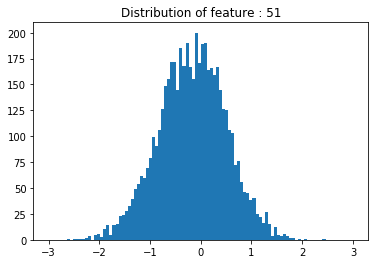

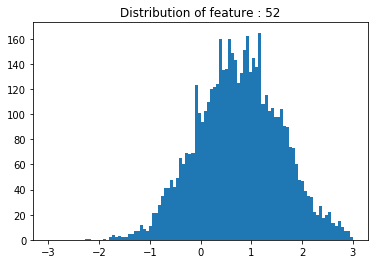

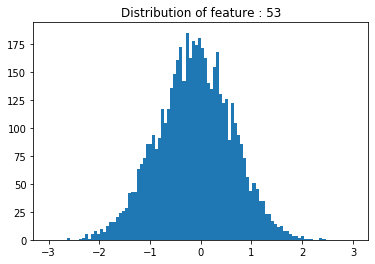

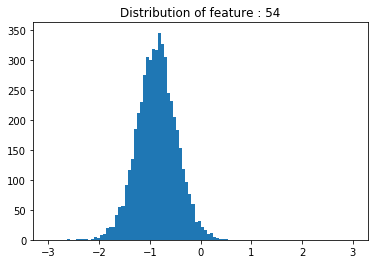

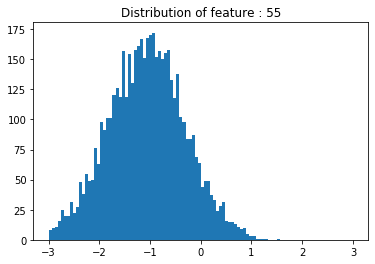

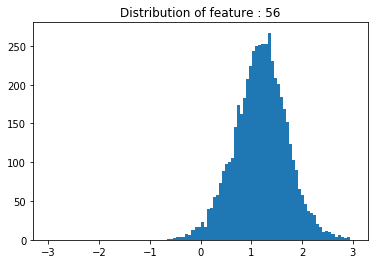

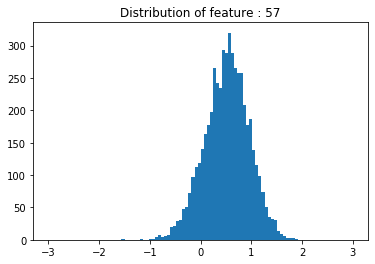

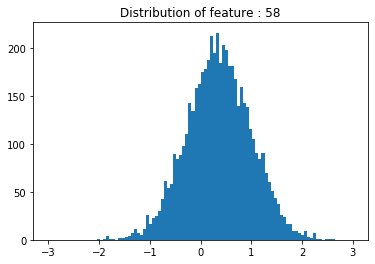

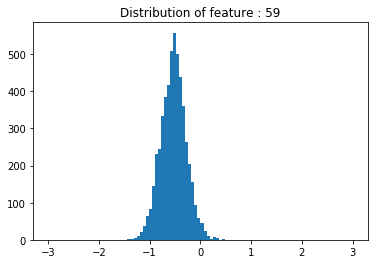

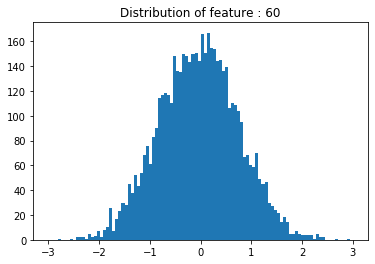

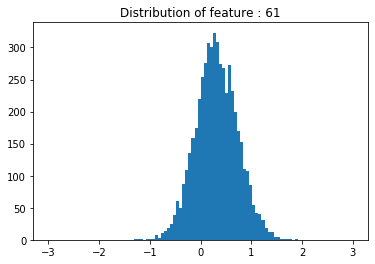

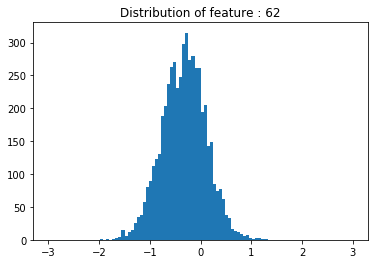

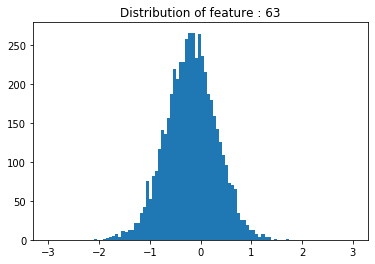

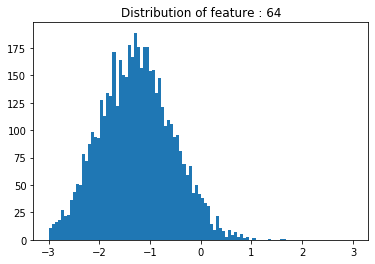

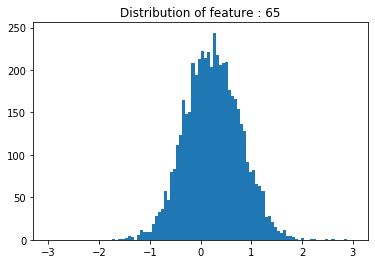

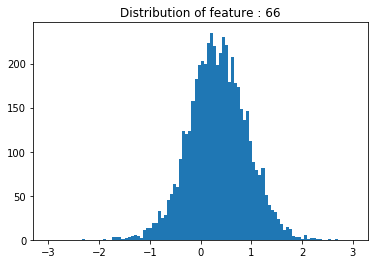

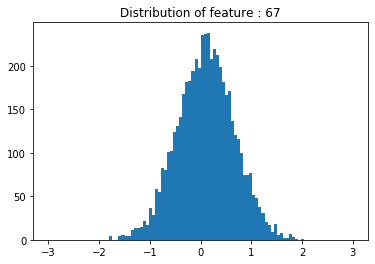

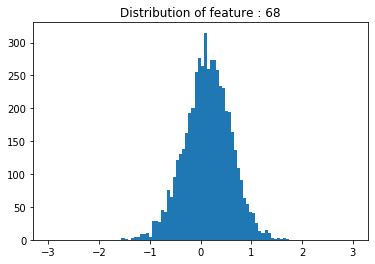

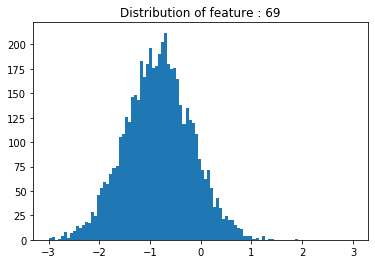

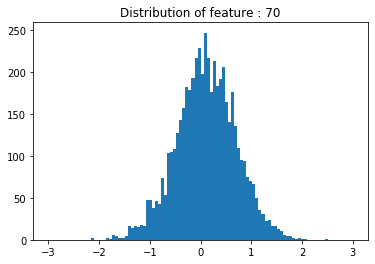

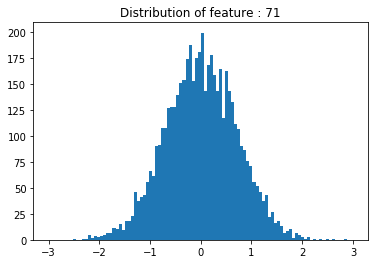

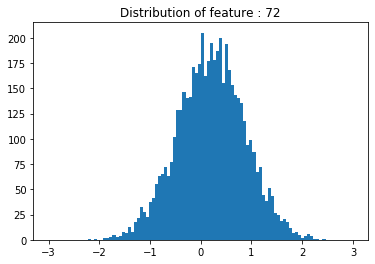

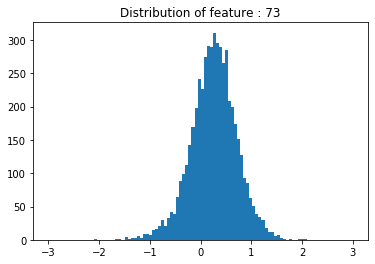

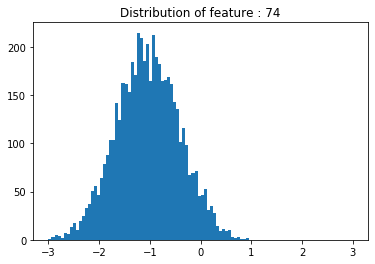

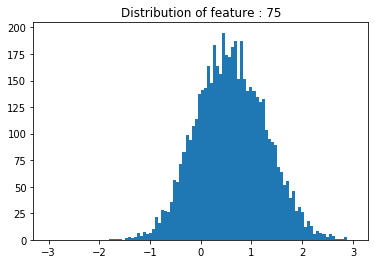

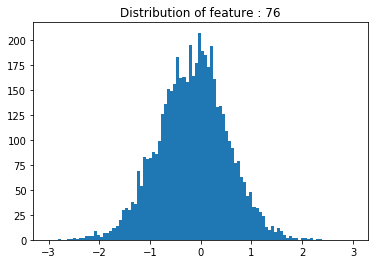

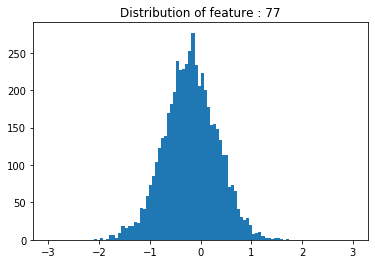

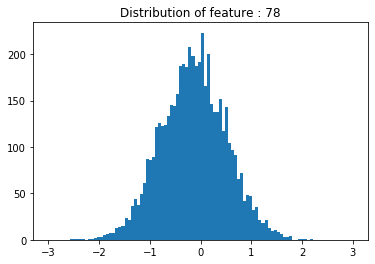

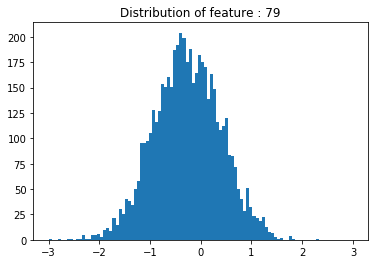

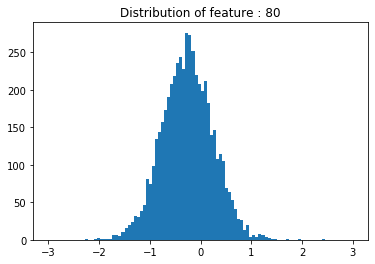

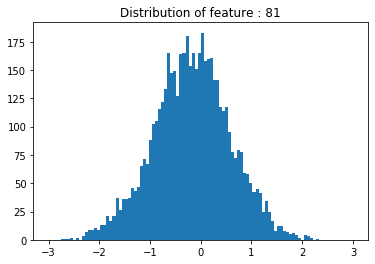

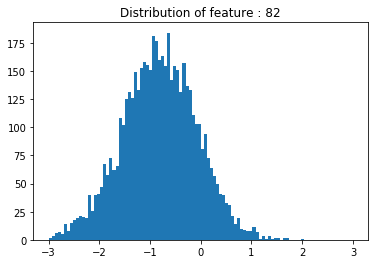

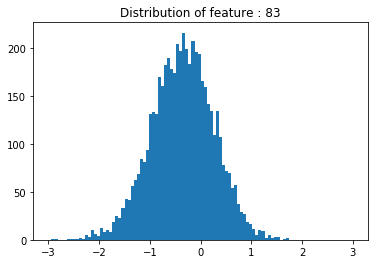

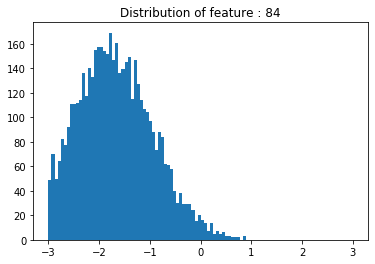

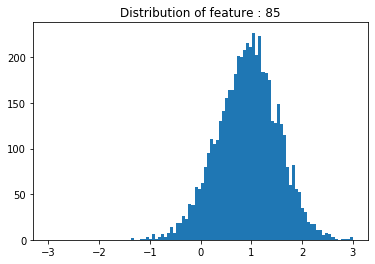

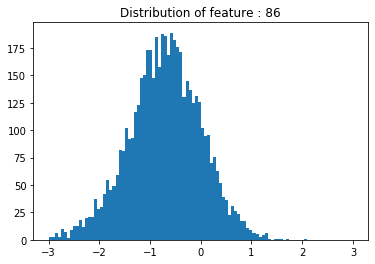

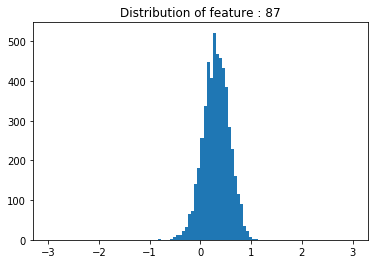

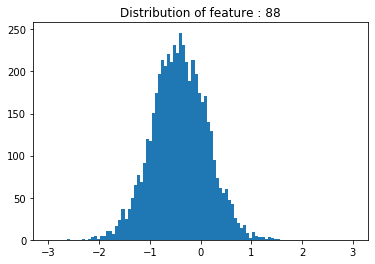

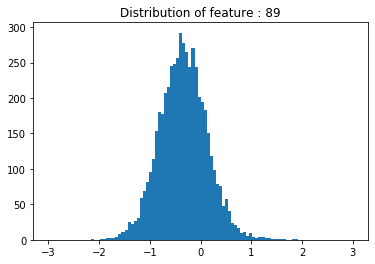

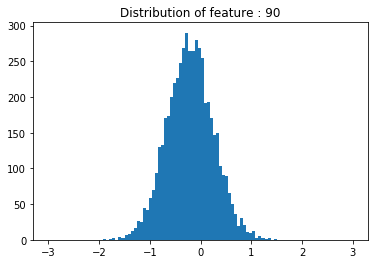

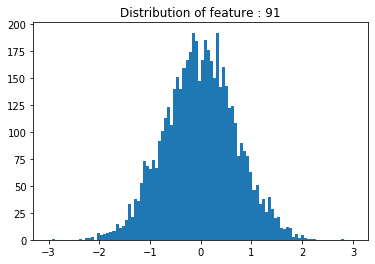

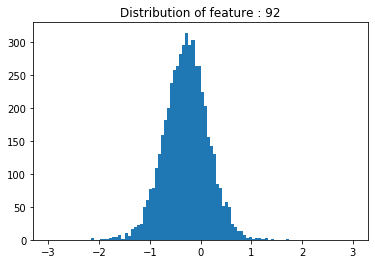

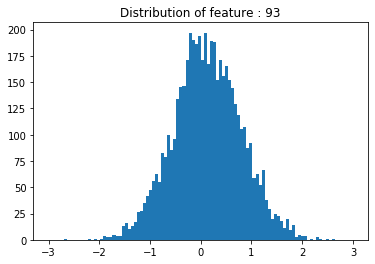

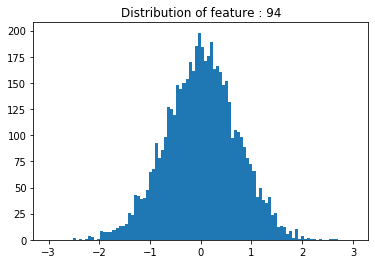

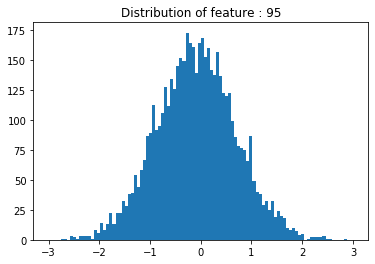

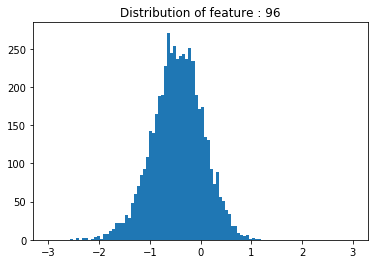

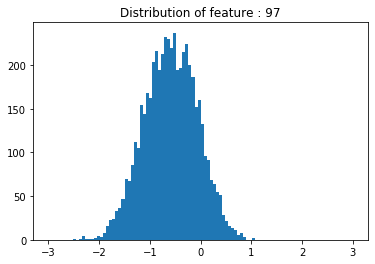

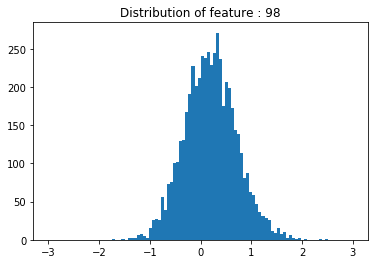

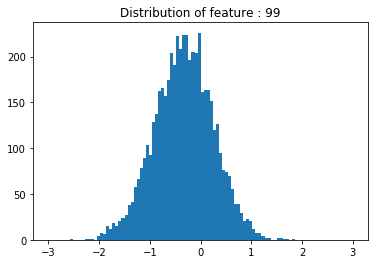

In [27]:
for i in range(len(lSpaceDF.columns)):
    feature = lSpaceDF.iloc[:,i]
    fig_name='figures/0004/distribution_train/plot/dim{}.png'.format(i)
    plt.hist(feature.values,bins=100,range=[-3,3])
    plt.title('Distribution of feature : {0}'.format(i))
    plt.savefig(fig_name)
    plt.show()
    
    


In [37]:
quant_train=lSpaceDF.quantile([0.25,0.75])
print(quant_train)
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])


min_max_train=lSpaceDF.apply(minMax)
print(min_max_train)

             0         1         2         3         4         5         6  \
0.25 -0.276742 -0.312702 -0.524978 -1.012696  0.412516 -0.098969  0.053140   
0.75  0.696228  0.756004  0.067737 -0.221659  1.272887  0.399177  0.824508   

             7         8         9  ...        90        91        92  \
0.25 -0.727715  0.356787 -0.455107  ... -0.517225 -0.481207 -0.562083   
0.75 -0.360069  1.144030  0.451745  ...  0.090039  0.460796 -0.010533   

            93        94        95        96        97        98        99  
0.25 -0.303413 -0.444365 -0.618595 -0.775760 -0.949326 -0.148344 -0.723347  
0.75  0.581268  0.488397  0.430864 -0.120498 -0.220132  0.538128  0.060843  

[2 rows x 100 columns]
            0         1         2         3         4         5         6  \
min -2.172156 -2.747009 -2.087641 -2.874890 -1.756810 -1.301721 -1.438905   
max  2.838280  3.155594  1.624935  1.905388  3.277387  1.683493  2.748438   

            7         8         9  ...        90        91

### Evaluation new images

In [103]:
def compute_score(el,i):
    if el>=quant_train.iloc[0,i] and el<=quant_train.iloc[1,i]:
        return 0
    if el>=min_max_train.iloc[0,i] and el<=min_max_train.iloc[1,i]:
        return 1
    else:
        return 5

In [113]:
img_path1="data/dog_cats"
img_path2="data/other_xrays"
img_path3="data/chest_xrays"
new_data1=[]
new_data2=[]
new_data3=[]
image_preprocess(img_path1,new_data1)
new_data1 = np.array(new_data1).reshape(-1, size, size, 3)  
new_data1 = new_data1/255
image_preprocess(img_path2,new_data2)
new_data2 = np.array(new_data2).reshape(-1, size, size, 3)  
new_data2 = new_data2/255
image_preprocess(img_path3,new_data3)
new_data3 = np.array(new_data3).reshape(-1, size, size, 3)  
new_data3 = new_data3/255

cat.jpeg
buddy.jpeg
dog_gray_scale.jpeg
cat_black_and_white.jpeg
brain.jpeg
leg_foot.jpeg
arm.jpeg
shoulder_xray.jpeg
NORMAL-754920-0001.jpeg
person40_virus_87.jpeg
BACTERIA-1602272-0001.jpeg
IM-0033-0001.jpeg


In [114]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)
z_points1 = vae.encoder.predict(new_data1)
z_points2 = vae.encoder.predict(new_data2)
z_points3= vae.encoder.predict(new_data3)

#df=pd.DataFrame(z_points)
#df.to_csv('data/new_images/latent_space_new_data.csv')
#print(z_points[0,0])

In [115]:
score1=np.empty((z_points1.shape[0],z_points1.shape[1]))
score2=np.empty((z_points2.shape[0],z_points2.shape[1]))
score3=np.empty((z_points3.shape[0],z_points3.shape[1]))
for i in range(z_points1.shape[0]):
    for j in range(z_points1.shape[1]):
        
        score1[i,j]=compute_score(z_points1[i,j],j)
        score1[i,j]=compute_score(z_points1[i,j],j)
    for i in range(z_points2.shape[0]):
    for j in range(z_points2.shape[1]):
        score2[i,j]=compute_score(z_points2[i,j],j)
for i in range(z_points3.shape[0]):
    for j in range(z_points3.shape[1]):
        score3[i,j]=compute_score(z_points3[i,j],j)
print('score dogs and cats')
print(score1)
print('score other xrays')
print(score2)
print('score chest xrays')
print(score3)
#img = vae.decoder.predict(z_points)
#%pylab inline
#for i in range(img.shape[0]):
#    imgplot = plt.imshow(img[i].squeeze(),cmap='gray_r')
#    plt.show()

score dogs and cats
[[1. 0. 1. 0. 1. 0. 1. 5. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.
  0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.
  0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.
  0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 5. 0. 0. 0. 1. 1. 0. 1. 0.
  0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 5. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 5. 1. 1. 1.
  0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1.
  1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
  0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 5. 0. 1. 1. 1. 1. 1. 0. 1.
  0. 1. 1. 1.]
 [0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
  1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
  0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 5. 1. 1. 1. 1. 1. 1. 0. 0.
  0. 0. 1. 0.]
 [1. 0. 1. 0. 1. 1. 1. 5. 1. 1. 0. 5. 0. 1. 1. 

In [117]:
total_score1=np.sum(score1,axis=1)
print(total_score1)
total_score2=np.sum(score2,axis=1)
print(total_score2)
total_score3=np.sum(score3,axis=1)
print(total_score3)


[57. 75. 70. 76.]
[107. 114.  89.  56.]
[64. 49. 44. 55.]


In [126]:
z_points4 = vae.encoder.predict(test_features_old)
score4=np.empty((z_points4.shape[0],z_points4.shape[1]))

In [129]:
for i in range(z_points4.shape[0]):
    for j in range(z_points4.shape[1]):
        score4[i,j]=compute_score(z_points4[i,j],j)
        if score4[i,j]==5:
            print(i)
            print(j)
print('score test xrays')
print(score4)
print(score4.shape)
total_score4=np.sum(score4,axis=1)
print(total_score4)
print(total_score4.shape)

10
46
37
22
55
44
146
95
158
88
169
77
182
15
182
48
182
99
297
53
431
20
490
94
499
59
511
1
521
36
567
17
568
12
580
20
score test xrays
[[1. 1. 1. ... 1. 1. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]]
(624, 100)
[63. 34. 53. 51. 51. 57. 43. 25. 41. 59. 68. 50. 42. 52. 63. 48. 36. 45.
 56. 39. 46. 41. 56. 43. 45. 55. 53. 53. 51. 58. 48. 42. 56. 48. 34. 52.
 54. 51. 53. 46. 39. 51. 56. 53. 42. 57. 62. 46. 49. 43. 50. 60. 54. 48.
 51. 52. 50. 54. 57. 56. 57. 44. 46. 56. 43. 58. 41. 59. 39. 50. 44. 54.
 59. 55. 43. 60. 40. 46. 43. 45. 41. 55. 51. 44. 45. 51. 66. 69. 41. 49.
 53. 46. 51. 55. 52. 52. 48. 42. 48. 51. 52. 51. 53. 54. 43. 41. 52. 50.
 55. 47. 37. 41. 55. 58. 42. 41. 45. 51. 54. 41. 41. 35. 43. 48. 48. 45.
 56. 36. 40. 51. 43. 43. 58. 45. 42. 64. 53. 51. 57. 39. 58. 54. 53. 50.
 50. 47. 56. 50. 44. 38. 51. 52. 54. 45. 51. 60. 60. 49. 59. 68. 51. 56.
 57. 62. 39. 51. 52. 39. 62. 52. 44. 

## Test data

### Average image test data

In [18]:
# latent space
vae = load_model(VariationalAutoencoder, RUN_FOLDER)
print(type(test_features_old))
z_points_old = vae.encoder.predict(test_features_old)
#df=pd.DataFrame(z_points_old)
#df.to_csv('latent_space_test.csv')

<class 'numpy.ndarray'>


(624, 100)
Populating the interactive namespace from numpy and matplotlib


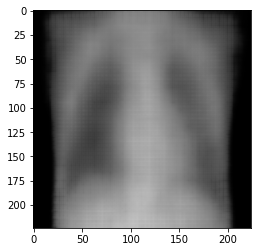

In [9]:
#data_old=pd.DataFrame(z_points_old)
#avg_img=data_old.mean(axis=0)
#avg_img.shape
avg_img=np.mean(z_points_old,axis=0)
avg_img=avg_img.reshape(1,100)
print(z_points_old.shape)
avg_img.shape
reconst_avg_img = vae.decoder.predict(avg_img)
%pylab inline
imgplot = plt.imshow(reconst_avg_img.squeeze(),cmap='gray_r')
plt.show()

### Dimensions distribution

/home/chiara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


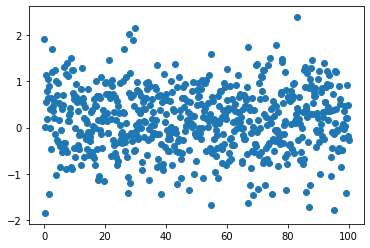

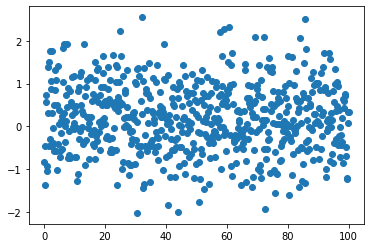

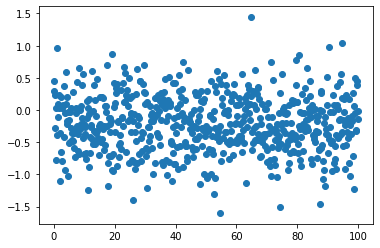

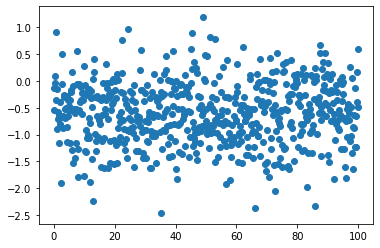

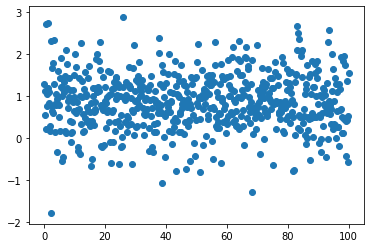

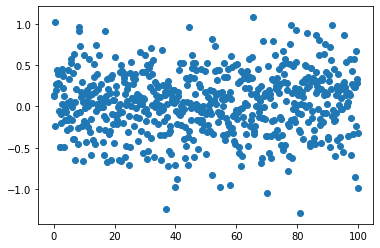

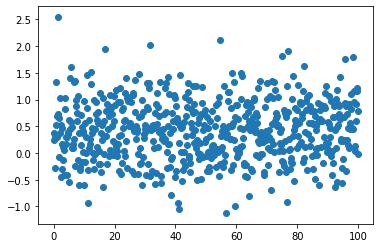

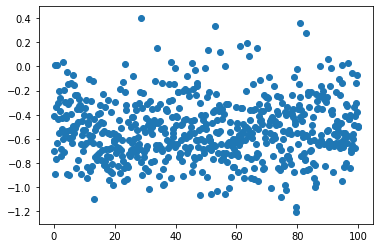

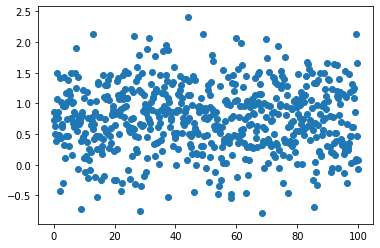

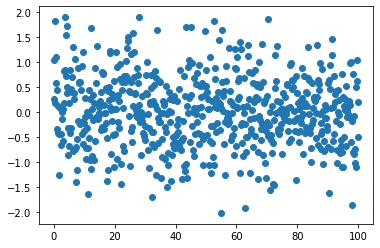

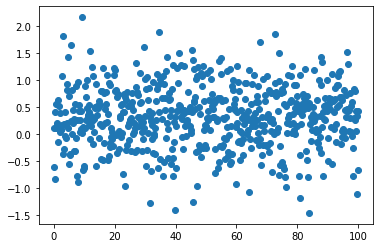

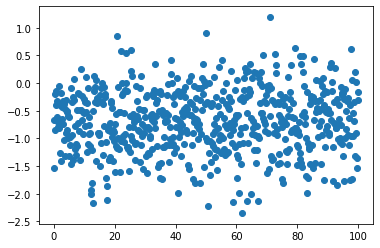

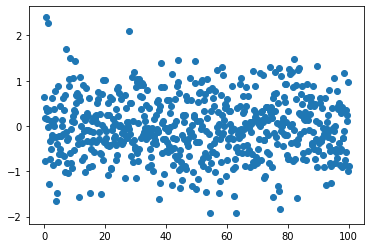

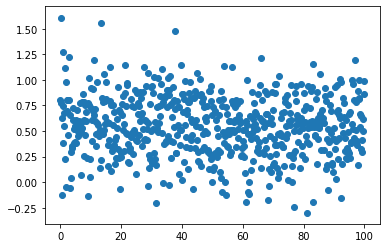

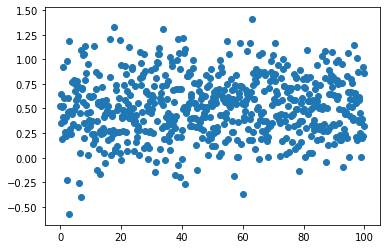

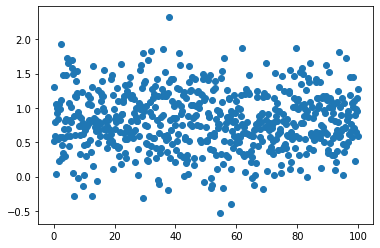

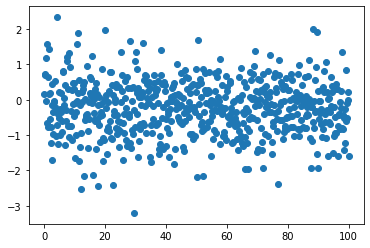

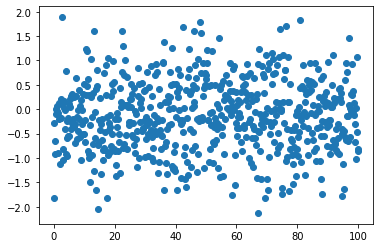

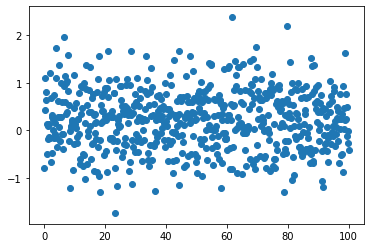

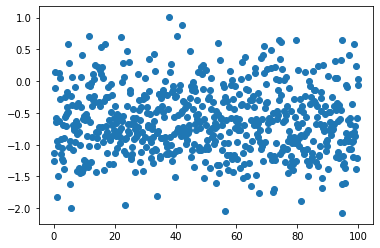

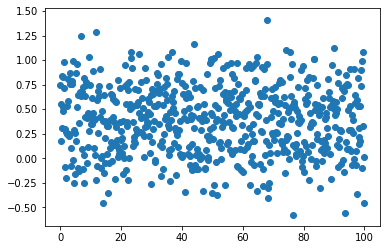

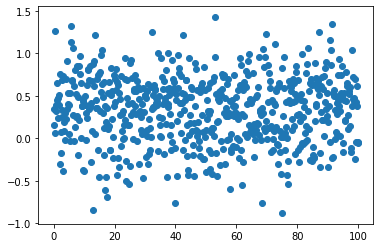

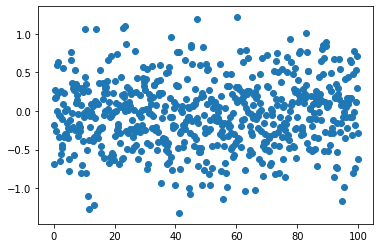

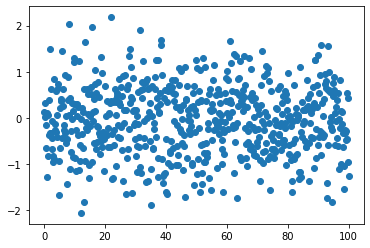

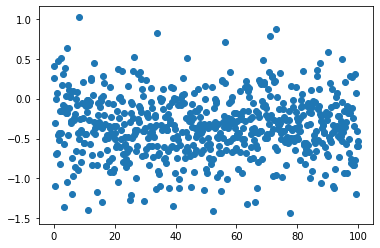

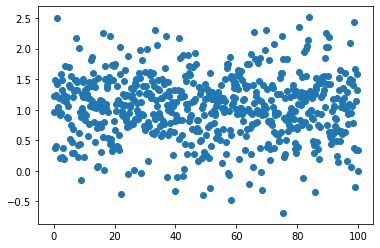

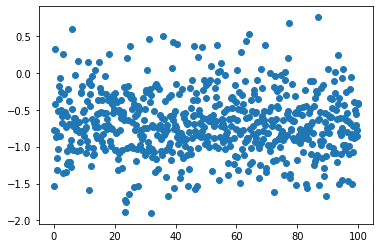

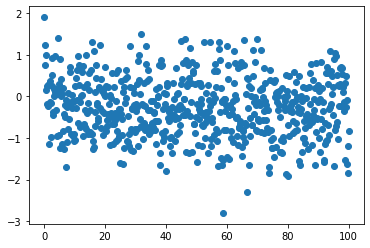

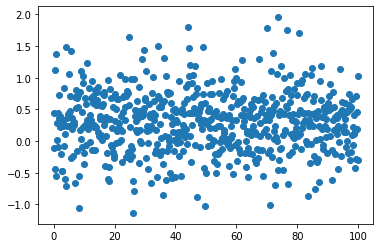

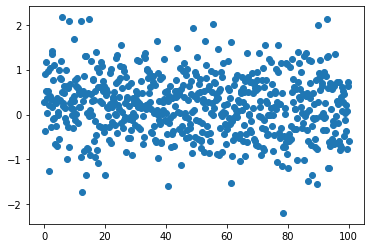

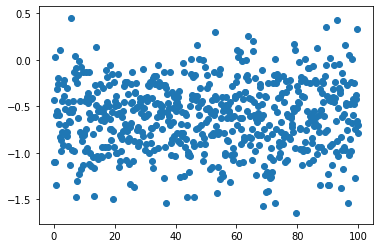

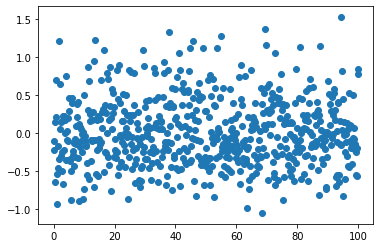

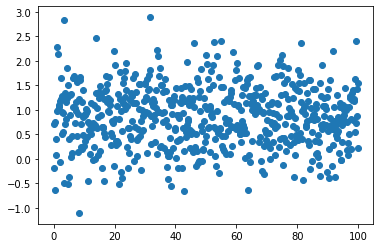

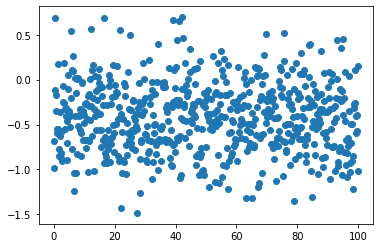

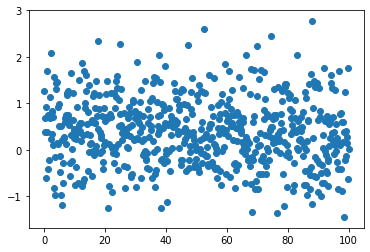

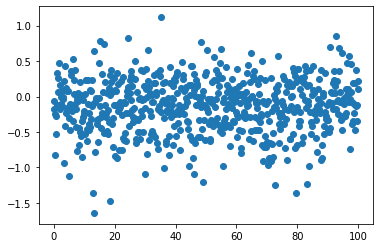

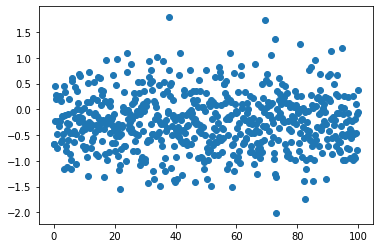

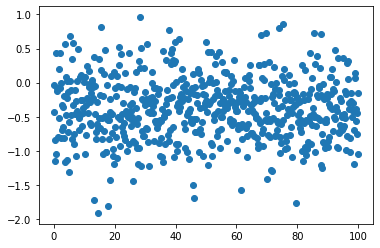

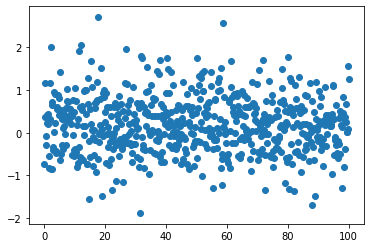

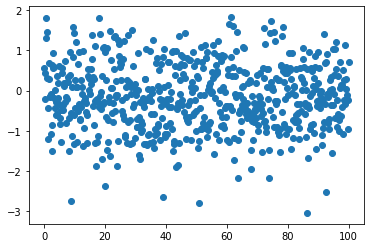

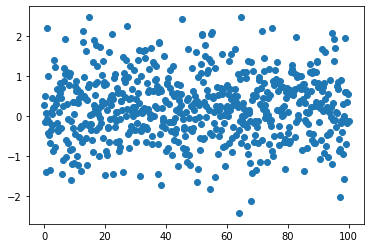

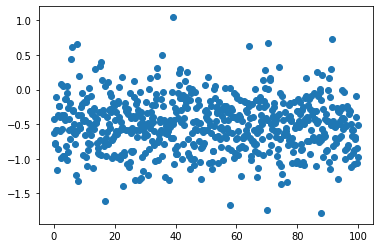

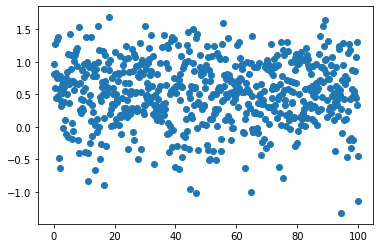

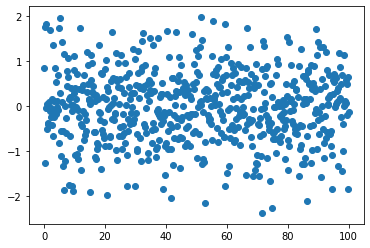

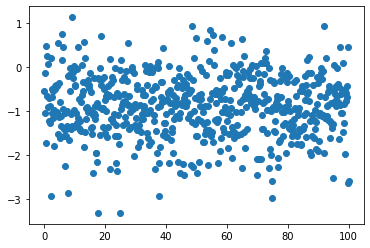

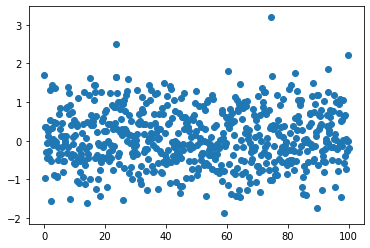

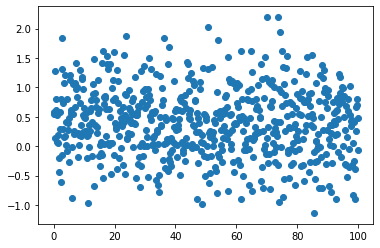

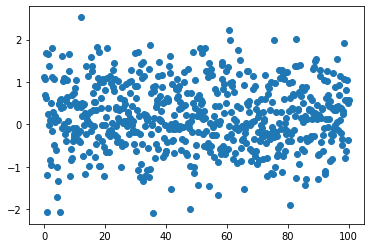

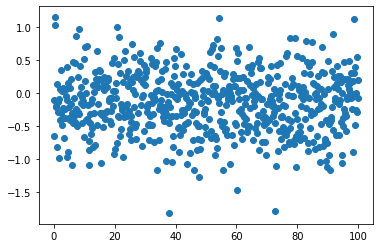

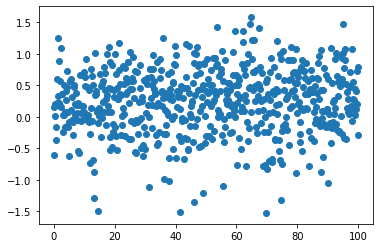

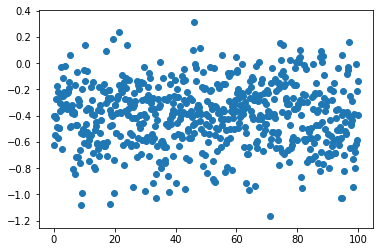

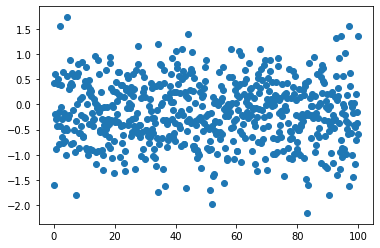

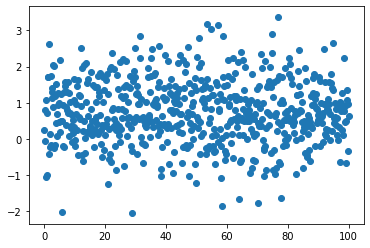

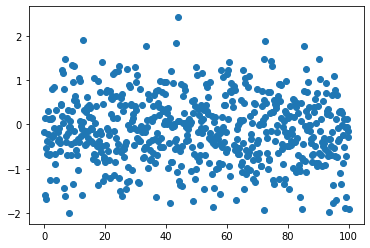

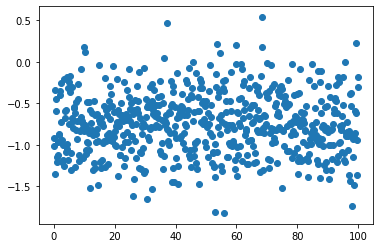

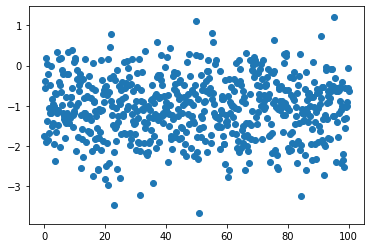

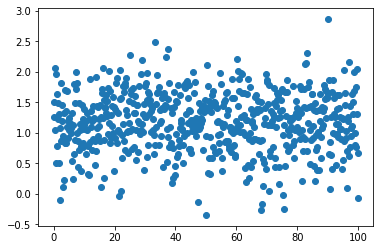

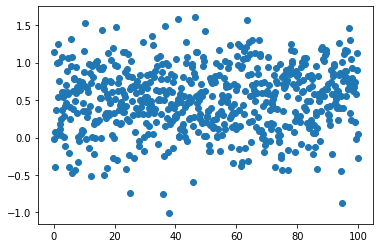

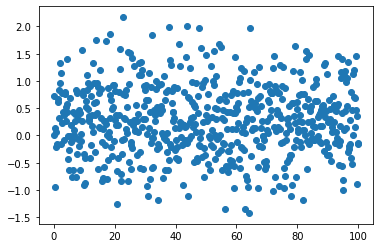

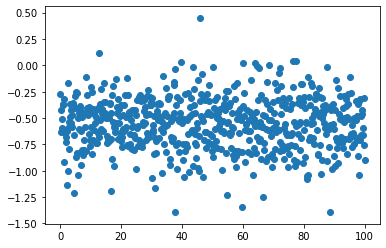

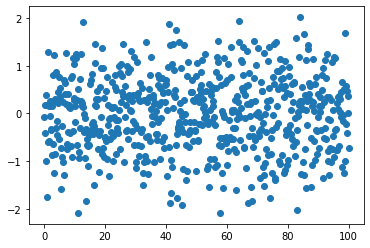

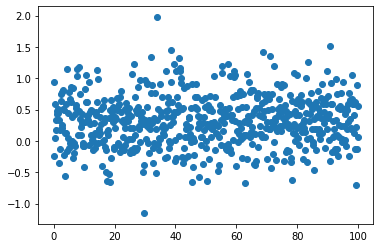

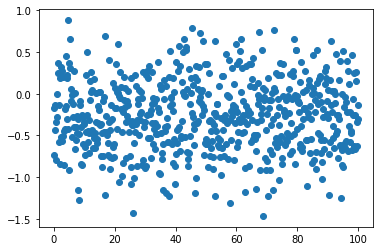

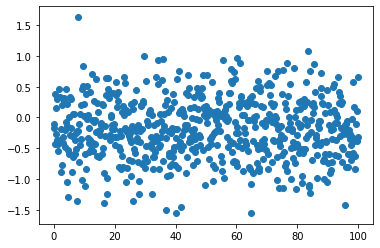

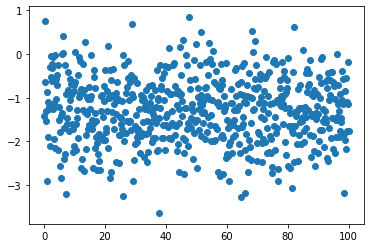

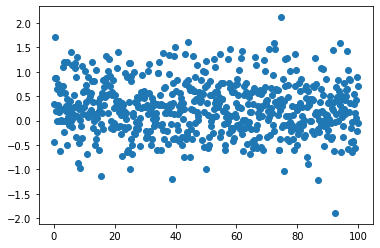

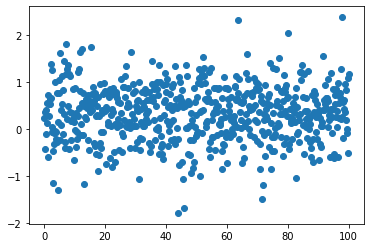

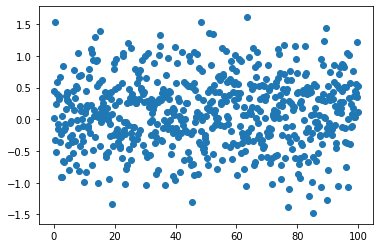

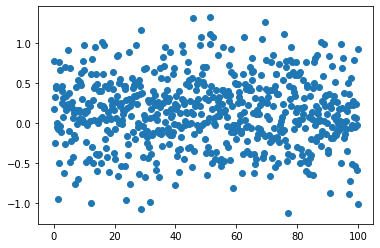

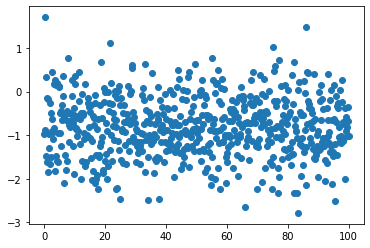

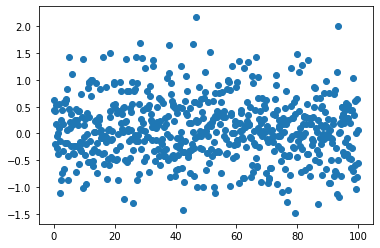

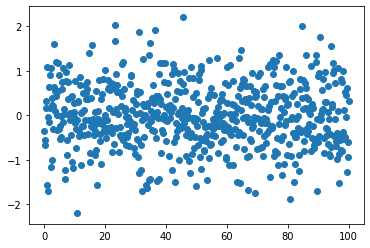

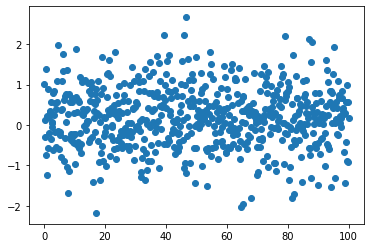

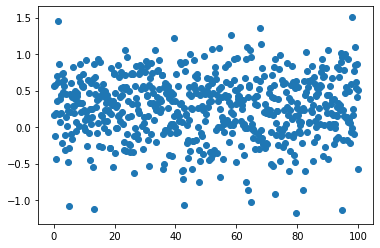

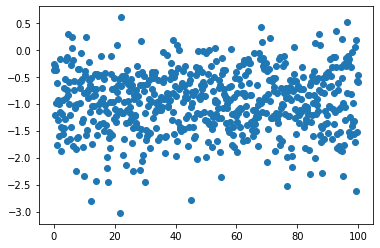

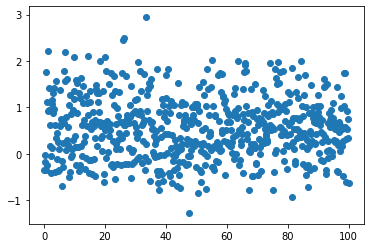

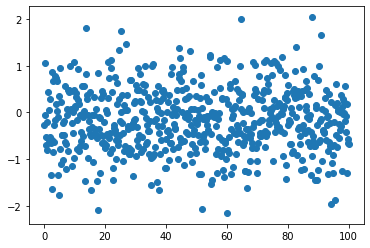

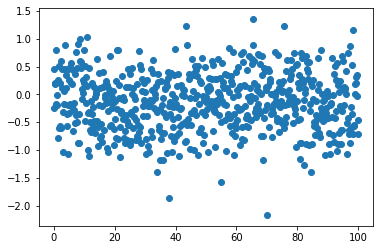

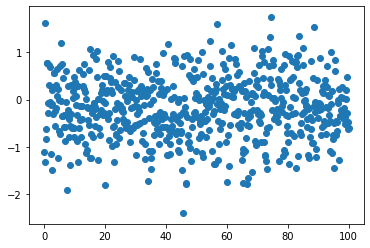

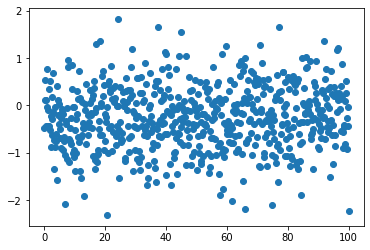

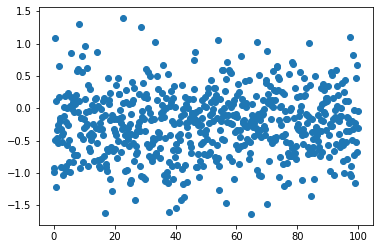

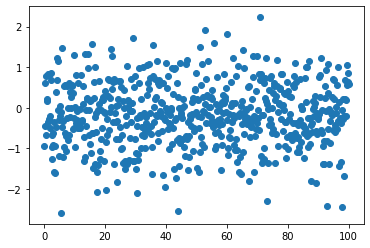

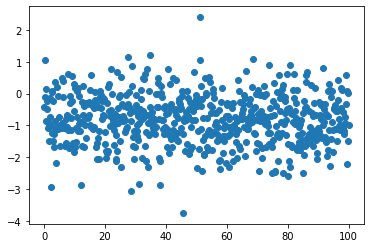

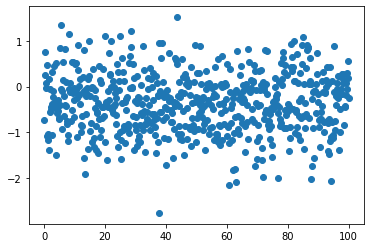

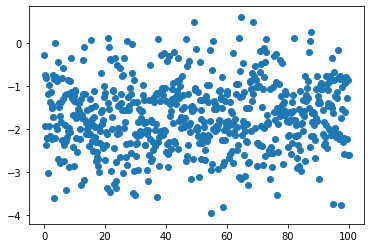

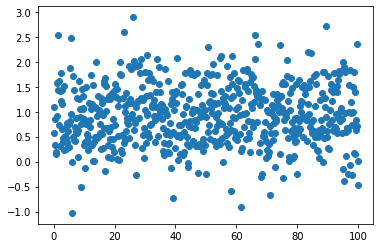

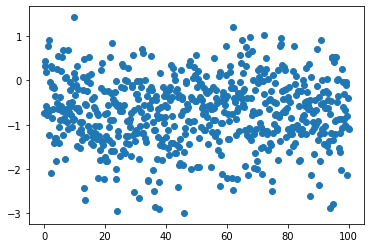

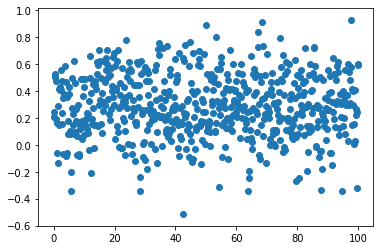

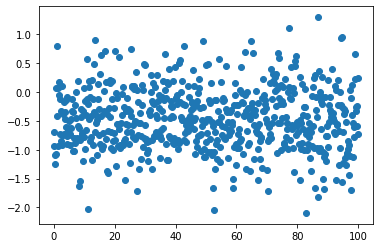

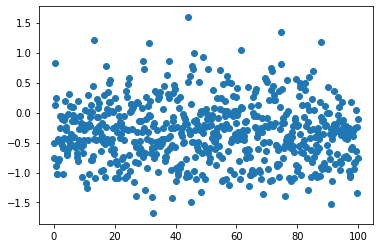

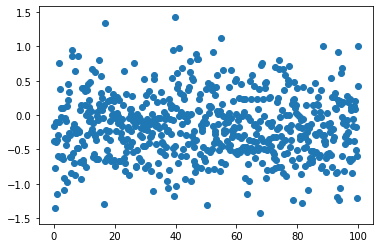

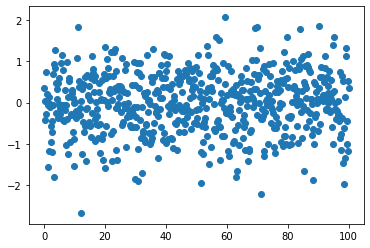

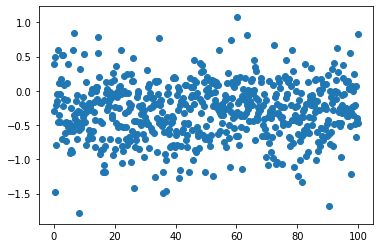

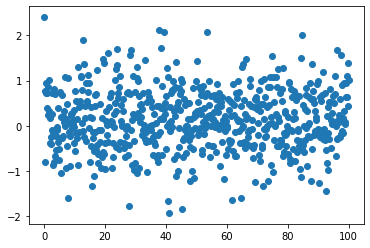

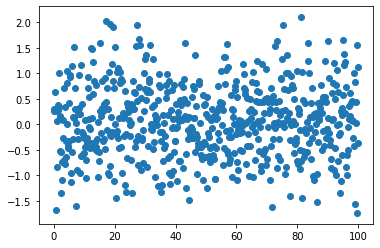

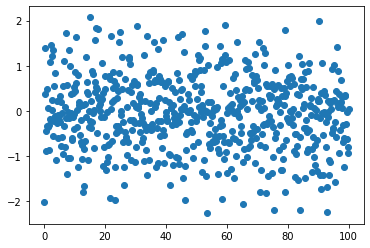

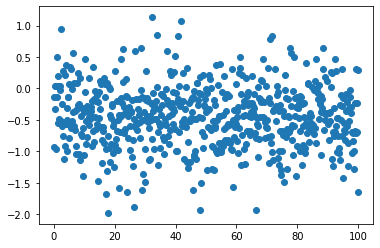

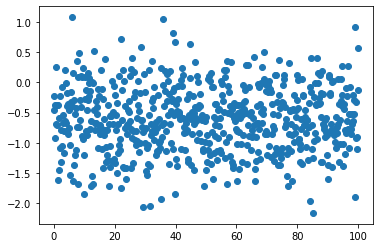

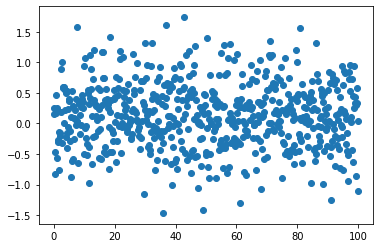

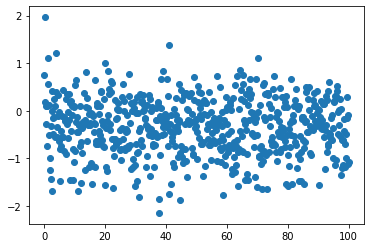

In [56]:
dim_x=np.shape(z_points_old)[0]
x=np.linspace(0,100,dim_x)
for col in range(np.shape(z_points_old)[1]):
    plt.figure()
    plt.scatter(x,z_points_old[:,col])
    direct='figures/0004/distribution_test/scatter/dim{}.png'.format(col)
    plt.savefig(direct)